# Days since first hospitalization

- Fit the doubling time based on all other input parameters by asking the user for 1 additional input: the number of days that have passed since the first hospitalization of a COVID19 patient.
- Allows the user to line up historical predicted hospitalizations with actuals.
- Properly seeds S, I, and R at current day by starting back at the time of the first hospitalization.
- Fitting process has the advantage of being _simple_, only requiring 1 additional input from the user.

In [1]:
%pylab inline
import pandas as pd
from typing import Dict, Generator, Tuple

Populating the interactive namespace from numpy and matplotlib


In [2]:
# download data from new york site
url = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv'
NYC_df = pd.read_csv(url,index_col=0,parse_dates=[0])


# next you'll take the total hospitlaized and calculate a doubling time for each new day
# the avg of these doubling times is likely closer to reality and this is what VH should do.  this will also allow me
# determine how accurate the model is for NYC and thus us even though we will have a different doubling time

In [3]:
NYC_df.head()
NYC_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2020-03-02 to 2020-04-06
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NEW_COVID_CASE_COUNT     36 non-null     int64  
 1   HOSPITALIZED_CASE_COUNT  36 non-null     int64  
 2   DEATH_COUNT              25 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.1 KB


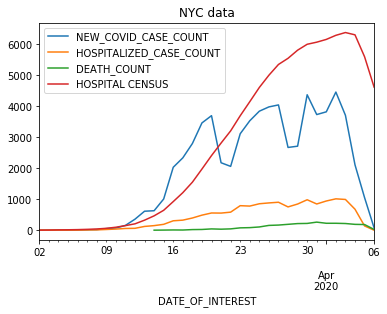

In [4]:
#If I'm going to get their hospitalized pt's by day I'm going to need to add the rows but remove pt's who have been
# been in the hospital longer than ~8 days...this should be function that adds a new row (total hospitalized)
COVID_LOS=7
census={}


# Loop through rows of dataframe by index i.e. from 0 to number of rows
for i in range(0, NYC_df.shape[0]):
   # get row contents as series using iloc{] and index position of row
    #print(NYC_df.iloc[i,1])
    
    #sum up all admissions that might still be in the hospital given the COVID LOS
    longestStay=i-COVID_LOS+1 if (i-COVID_LOS+1)> 0  else 0
    sum=NYC_df.iloc[i,1]
    for j in range(longestStay,i):
        sum=NYC_df.iloc[j,1]+sum   
    
    census[NYC_df.index[i]]=sum
    sum=0

#add COVID census to df
NYC_df['HOSPITAL CENSUS']=census.values()

NYC_df.plot(title="NYC data")


In [26]:
actual_hsp=NYC_df.iloc[0:32,3].tolist()
actual_hsp

[3,
 6,
 11,
 15,
 20,
 29,
 41,
 62,
 97,
 149,
 207,
 325,
 465,
 644,
 925,
 1213,
 1551,
 1976,
 2410,
 2815,
 3208,
 3696,
 4150,
 4610,
 5005,
 5352,
 5551,
 5813,
 6004,
 6072,
 6161,
 6293]

In [27]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir(
    s: float, i: float, r: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)


def sim_sir_df(
    s: float, i: float, r: float, beta: float, gamma: float, n_days
) -> pd.DataFrame:
    """Simulate the SIR model forward in time."""
    return pd.DataFrame(
        data=gen_sir(s, i, r, beta, gamma, n_days),
        columns=("day", "susceptible", "infected", "recovered"),
    )


def get_dispositions(
    patients: np.ndarray,
    rates: Dict[str, float],
    market_share: float,
) -> Dict[str, np.ndarray]:
    """Get dispositions of patients adjusted by rate and market_share."""
    return {
        key: patients * rate * market_share
        for key, rate in rates.items()
    }


def build_admits_df(n_days, dispositions) -> pd.DataFrame:
    """Build admits dataframe from Parameters and Model."""
    days = np.arange(0, n_days + 1)
    projection = pd.DataFrame({
        "day": days,
        **dispositions,
    })
    # New cases
    admits_df = projection.iloc[:-1, :] - projection.shift(1)
    admits_df["day"] = range(admits_df.shape[0])
    return admits_df


def build_census_df(
    admits_df: pd.DataFrame, lengths_of_stay
) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""
    n_days = np.shape(admits_df)[0]
    census_dict = {}
    for key, los in lengths_of_stay.items():
        census = (
            admits_df.cumsum().iloc[:-los, :]
            - admits_df.cumsum().shift(los).fillna(0)
        ).apply(np.ceil)
        census_dict[key] = census[key]

    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", *lengths_of_stay.keys()]]
    census_df = census_df.head(n_days)
    return census_df


In [42]:
rates = {"hospitalized": 0.05,
         "icu": 0.0075,
         "ventilated": 0.005,
}

lengths_of_stay = {
        "hospitalized": 7,
         "icu": 9,
         "ventilated": 10,
}

#population_size = 4119405
population_size = 8336817
#n_days_since_first_hospitalized = 20
n_days_since_first_hospitalized = 32

#current_hospitalized = 32
current_hospitalized = 7212.0
#current_hospitalized = 547

current_hospitalized_array=NYC_df['HOSPITAL CENSUS']

def run_projection(doubling_time):
    intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1

    recovery_days = 14.0
    market_share = 0.15
    initial_i = 1/rates['hospitalized']/market_share
    S, I, R = population_size-initial_i, initial_i, 0
    # mean recovery rate, gamma, (in 1/days).
    gamma = 1/recovery_days

    # Contact rate, beta
    beta = (intrinsic_growth_rate+gamma)/S # {rate based on doubling time} / {initial S}

    n_days = 100
    
    raw_df = sim_sir_df(S,I,R,beta,gamma,n_days)
    i_dict_v = get_dispositions(raw_df.infected, rates, market_share)
    r_dict_v = get_dispositions(raw_df.recovered, rates, market_share)

    dispositions = {
        key: value + r_dict_v[key]
        for key, value in i_dict_v.items()
    }

    dispositions_df = pd.DataFrame(dispositions)
    admits_df = admits_df = build_admits_df(n_days, dispositions)
    census_df = build_census_df(admits_df, lengths_of_stay)
    return raw_df, admits_df, census_df

def obs_pred_diff(doubling_time):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2


def obs_pred_diff_days_since(n_days_since_first_hospitalized):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized)**2

def obs_pred_diff_admits(n_days_since_first_hospitalized, doubling_time ):
    raw_df, admits_df, census_df = run_projection(doubling_time)
    
    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df['hospitalized'].loc[n_days_since_first_hospitalized]
    
    ## compare against the actual (user inputed) number 
    ## root squared difference is the loss to be optimized
    return (((current_hospitalized_array[n_days_since_first_hospitalized] - pred_current_hospitalized)**2)**0.5)

### Either fit `n_days_since_first_hospitalized` given a `doubling_time`:

In [43]:
doubling_time = 4.0
for ds in range(1,33):
    print(ds, obs_pred_diff_days_since(ds))

1 51998521.0
2 51998521.0
3 51998521.0
4 51984100.0
5 51984100.0
6 51969681.0
7 51955264.0
8 51955264.0
9 51940849.0
10 51926436.0
11 51912025.0
12 51897616.0
13 51868804.0
14 51854401.0
15 51811204.0
16 51782416.0
17 51739249.0
18 51696100.0
19 51624225.0
20 51566761.0
21 51480625.0
22 51380224.0
23 51251281.0
24 51122500.0
25 50951044.0
26 50751376.0
27 50523664.0
28 50239744.0
29 49914225.0
30 49519369.0
31 49056016.0
32 48511225.0


### Or fit `doubling_time` given `n_days_since_first_hospitalized`:

In [44]:
for dt in np.linspace(1,11,21):
    print(dt, obs_pred_diff(dt))

1.0 51998521.0
1.5 60575089.0
2.0 593019904.0
2.5 401956.0
3.0 31438449.0
3.5 44315649.0
4.0 48511225.0
4.5 50154724.0
5.0 50893956.0
5.5 51279921.0
6.0 51494976.0
6.5 51624225.0
7.0 51710481.0
7.5 51782416.0
8.0 51811204.0
8.5 51854401.0
9.0 51868804.0
9.5 51883209.0
10.0 51897616.0
10.5 51912025.0
11.0 51926436.0


In [45]:
precision_steps=100
days_to_sim=30
doubling_times = np.linspace(1,6,precision_steps)
days=np.arange(1,days_to_sim)
data=[]
for d in days:
    for dt in doubling_times:
        values=[d, dt, obs_pred_diff_admits(d, dt)]
        #print(values)
        data.append(values)
diffs=pd.DataFrame(data, columns=['days', 'doubling time', 'diff'])
# go through diffs and add up the diff errors for each doubling time.  add this cumulative error to 
# a list for presentation


In [46]:
#DT_RMSEs=diffs.groupby('doubling time')['diff'].sum()
DT_RMSEs=diffs.groupby('doubling time', as_index=False).agg({'diff' : 'sum'})
DT_RMSEs

,doubling time,diff
0,1.000000,430129.0
1,1.050505,418507.0
2,1.101010,406529.0
3,1.151515,394206.0
4,1.202020,382579.0
...,...,...
95,5.797980,62168.0
96,5.848485,62172.0
97,5.898990,62177.0
98,5.949495,62182.0


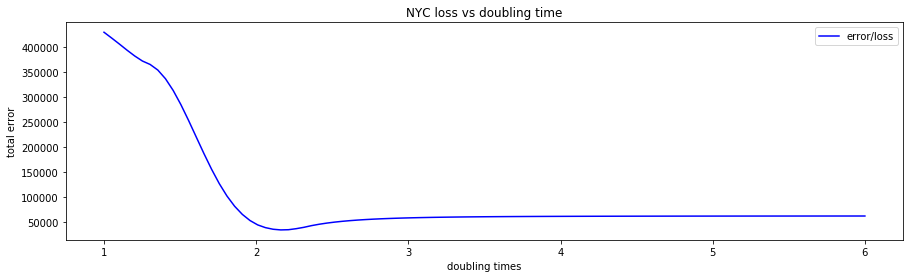

In [47]:
fig=plt.figure(figsize=(15,4))
ax=fig.add_subplot(1,1,1)
ax.label_outer()
ax.plot(DT_RMSEs['doubling time'],DT_RMSEs['diff'],label='error/loss', color='b')
ax.legend()
plt.ylabel('total error')
plt.xlabel('doubling times')
plt.title("NYC loss vs doubling time")
plt.show()

In [48]:
DT_RMSEs[DT_RMSEs['diff']==DT_RMSEs['diff'].min()]

,doubling time,diff
23,2.161616,34343.0


In [49]:
fitted_doubling_time = DT_RMSEs[DT_RMSEs['diff']==DT_RMSEs['diff'].min()]["doubling time"]
fitted_doubling_time

23    2.161616
Name: doubling time, dtype: float64

Brut force optimization, but could be implemented however. Just need to minimize the `obs_pred_diff` as a function of `doubling_times`

Then you can run the projection starting at the fitted value. This gives you a projection that starts from the day of the first hospitalization. We'll subtract off `n_days_since_first_hospitalized` to make day 0 be today.

In [50]:
#TODO fix this and then use number to set error thresholds for recalculation

raw_df, admits_df, census_df = run_projection(fitted_doubling_time)
raw_df['day'] = raw_df['day'] - n_days_since_first_hospitalized
admits_df['day'] = admits_df['day'] - n_days_since_first_hospitalized
census_df['day'] = census_df['day'] - n_days_since_first_hospitalized

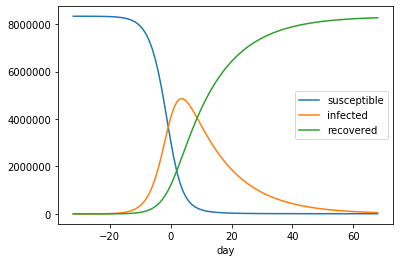

In [37]:
raw_df.set_index('day').plot()

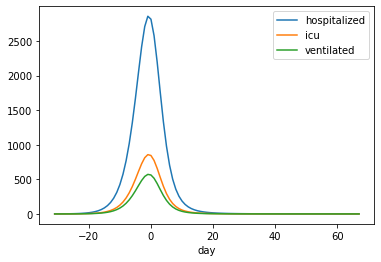

In [38]:
admits_df.set_index('day').plot()

In [39]:
actual_hsp_array = np.array(actual_hsp + [np.nan for i in range(census_df.shape[0] - len(actual_hsp))]) 
census_df['actual_hospitalized'] = actual_hsp_array

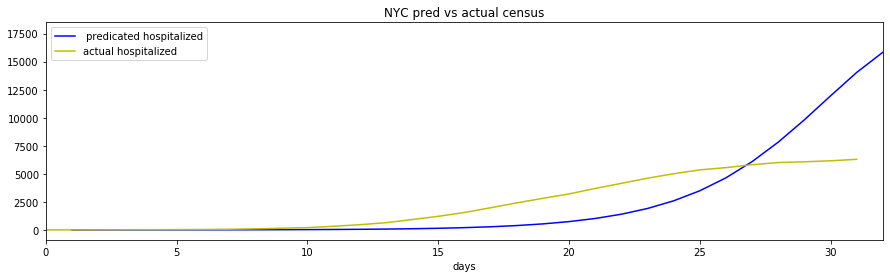

In [41]:
fig=plt.figure(figsize=(15,4))
ax=fig.add_subplot(1,1,1)
ax.label_outer()
ax.plot(census_df['hospitalized'], label=' predicated hospitalized', color='b')
ax.plot(census_df['actual_hospitalized'], label='actual hospitalized', color='y')
ax.legend()
ax.set_xlim(0,32)
plt.xlabel('days')
plt.title("NYC pred vs actual census")
plt.show()

In [ ]:
census_df.set_index('day').head(30)